# Задача 6. Компьютерное зрение: задача сегментации



Сделать train/test split (или кросс-валидацию) в следующих формах:
- Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. 
- Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. 
- Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- Попробовать улучшить качество изменяя архитектуру.

Дополнительно:
- Зафиксировать все сиды чтобы более-менее воспроизводились результаты.
- Добавить метрику **jaccard index**. 
- Визуализировать topN самых плохих предсказаний.
- Посчитать метрики для батча и для теста. 

## Подготовка

In [ ]:
!pip install torchmetrics

In [39]:
import copy
import pandas as pd
import random
import seaborn as sns
import torch
import torch.utils.data
import torchmetrics

from matplotlib import pyplot as plt
from pathlib import Path
from torch import nn
from torchvision import io
from torchvision import transforms
from torchvision.transforms import functional
from tqdm.auto import tqdm, trange

In [40]:
def reset_random_seeds():
    torch.manual_seed(42)
    random.seed(42)

## Датасет

### Загрузка

In [ ]:
!gdown 11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe

Downloading...
From: https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe
To: /content/dataset.zip
100% 154M/154M [00:00<00:00, 160MB/s]


In [ ]:
!unzip dataset.zip

### Подготовка

In [31]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform=lambda x: x):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(io.read_image(str(self.images[idx])) / 255)
        mask = self.transform(io.read_image(str(self.masks[idx])) / 255)
        return img, mask

In [32]:
def show_images(imgs):
    n = len(imgs)
    _, axs = plt.subplots(ncols=n)
    for i in range(len(imgs)):
        axs[i].imshow(functional.to_pil_image(imgs[i]))
        axs[i].axis("off")

In [33]:
image_paths = sorted(Path("dataset/images").iterdir())
mask_paths = sorted(Path("dataset/masks").iterdir())

### Разделение датасета на тренировочный и тестовый

Возьмем 5% на тестовый (100 изображений).

In [34]:
test_portion = 0.05
test_len = int(len(image_paths) * test_portion)

In [35]:
test_dataset = MyDataset(images=image_paths[:test_len], masks=mask_paths[:test_len])
train_dataset = MyDataset(images=image_paths[test_len:], masks=mask_paths[test_len:])

### Инфо

Train size: 1900
Test size: 100


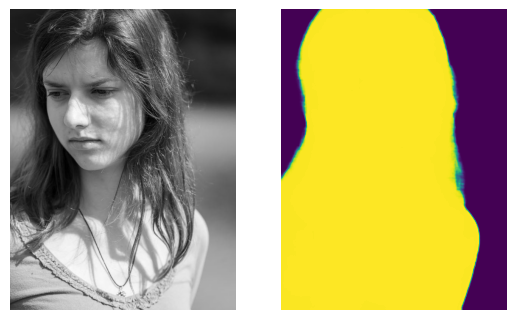

In [13]:
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

image, mask = train_dataset[0]
show_images([image, mask])

## Обучение

### Подготовка

#### U-Net

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, n_down):
        super().__init__()

        self.enc_layers = nn.ModuleList([DoubleConv(in_channels, in_channels * 2)])

        for _ in range(n_down):
            in_channels *= 2
            self.enc_layers.append(nn.Sequential(nn.MaxPool2d(2, 2), DoubleConv(in_channels, in_channels * 2)))

    def forward(self, x):
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class Decoder(nn.Module):
    def __init__(self, in_channels, n_up):
        super().__init__()

        self.dec_layers = nn.ModuleList()
        for _ in range(n_up):
            out_channels = in_channels // 2
            self.dec_layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                DoubleConv(in_channels, out_channels),
            ]
            in_channels = out_channels

    def forward(self, x1, x2s):
        for (up_conv, double_conv), x2 in zip(zip(self.dec_layers[::2], self.dec_layers[1::2]), x2s[::-1]):
            x1 = up_conv(x1)

            diffY = x2.size(dim=2) - x1.size(dim=2)
            diffX = x2.size(dim=3) - x1.size(dim=3)

            if diffY > 0 or diffX > 0:
                x1 = nn.functional.pad(x1, [0, diffX, 0, diffY])

            x = torch.cat([x2, x1], dim=1)
        return double_conv(x)


# Будем везде использовать 4 уровня
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(in_channels=3, n_down=4)
        self.decoder = Decoder(in_channels=96, n_up=4)
        self.out_conv = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        x = self.out_conv(x)
        return x

#### Замеры

In [12]:
criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.JaccardIndex(task="binary")

In [13]:
def calc_jaccard(pred, y):
    return jaccard(pred.cpu(), y.cpu() > jaccard.threshold)

In [14]:
def train_epoch(model, optimizer, loader):
    model.train()

    loss_sum = 0
    metric_sum = 0

    for X, y in tqdm(loader, desc="Training batch", disable=False):
        X, y = X.cuda(), y.cuda()

        pred = model(X)
        loss = criterion(pred, y)
        metric = calc_jaccard(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        metric_sum += metric.item()

    return loss_sum / len(loader), metric_sum / len(loader)


def test(model, loader):
    model.eval()

    loss_sum = 0
    metric_sum = 0
    with torch.no_grad():
        for X, y in tqdm(loader, desc="Test batch", disable=False):
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            loss_sum += criterion(pred, y).item()
            metric_sum += calc_jaccard(pred, y).item()

    return loss_sum / len(loader), metric_sum / len(loader)


def train(model, optimizer, train_loader, test_loader, epochs=30, checkpoints_dir=None):
    if checkpoints_dir is not None:
        checkpoints_dir = Path(checkpoints_dir)
        checkpoints_dir.mkdir(parents=True, exist_ok=True)

    stats = []
    for epoch_i in trange(epochs, desc="Epoch"):
        loss_train, metric_train = train_epoch(
            model, optimizer, train_loader
        )
        loss_test, metric_test = test(model, test_loader)
        stats += [
            (epoch_i, "Loss", "Train", loss_train),
            (epoch_i, "Jaccard", "Train", metric_train),
            (epoch_i, "Loss", "Test", loss_test),
            (epoch_i, "Jaccard", "Test", metric_test),
        ]

        if checkpoints_dir is not None:
            torch.save(model.state_dict(), checkpoints_dir / f"epoch_{epoch_i}.pt")

    return pd.DataFrame(stats, columns=stats_columns)

#### Статистика

In [4]:
stats_columns = ["Epoch", "Statistic", "Dataset", "Value"]


def helper(stats, title, ax):
    for _, row in stats[stats["Statistic"] == title].iterrows():
        if row["Dataset"] != "Train":
            ax.text(
                row["Epoch"], row["Value"], f"{row['Value']:.3f}", horizontalalignment="center",
                verticalalignment="bottom" if row["Dataset"] == "Train" else "top",
            )


def show_stats(stats, title, values=True):
    fig, (ax_loss, ax_jaccard) = plt.subplots(nrows=2, sharex=True, figsize=(15, 7))

    sns.lineplot(
        stats[stats["Statistic"] == "Loss"], x="Epoch", y="Value", hue="Dataset", marker="o", ax=ax_loss)
    ax_loss.set_title("Loss")
    if values:
        helper(stats, "Loss", ax_loss)

    sns.lineplot(stats[stats["Statistic"] == "Jaccard"], x="Epoch", y="Value", hue="Dataset", marker="o", ax=ax_jaccard)
    ax_jaccard.set_title("Jaccard index")
    if values:
        helper(stats, "Jaccard", ax_jaccard)

    fig.suptitle(title)
    fig.tight_layout()

In [5]:
def show_worst_test_cases(model: nn.Module, n=None, idx=None) -> list[int]:
    if idx is None:
        test_metrics = []
        with torch.no_grad():
            for i, (X, y) in enumerate(test_dataset):
                pred = model(X.cuda().unsqueeze(0))[0].cpu()
                test_metrics.append((calc_jaccard(pred, y).item(), i))

        idx = [i for _, i in sorted(test_metrics)[:n]]

    with torch.no_grad():
        for i in idx:
            X, y = test_dataset[i]
            pred = model(X.cuda().unsqueeze(0))[0].cpu()
            show_images([X, nn.functional.sigmoid(pred), y])

    return idx

### Переобучение на одном батче

In [46]:
reset_random_seeds()

batch_size = 4

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

In [ ]:
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters())

stats = train(model, optimizer, train_loader, test_loader, epochs=80)

In [48]:
stats.to_csv("stats_overtrain.csv")

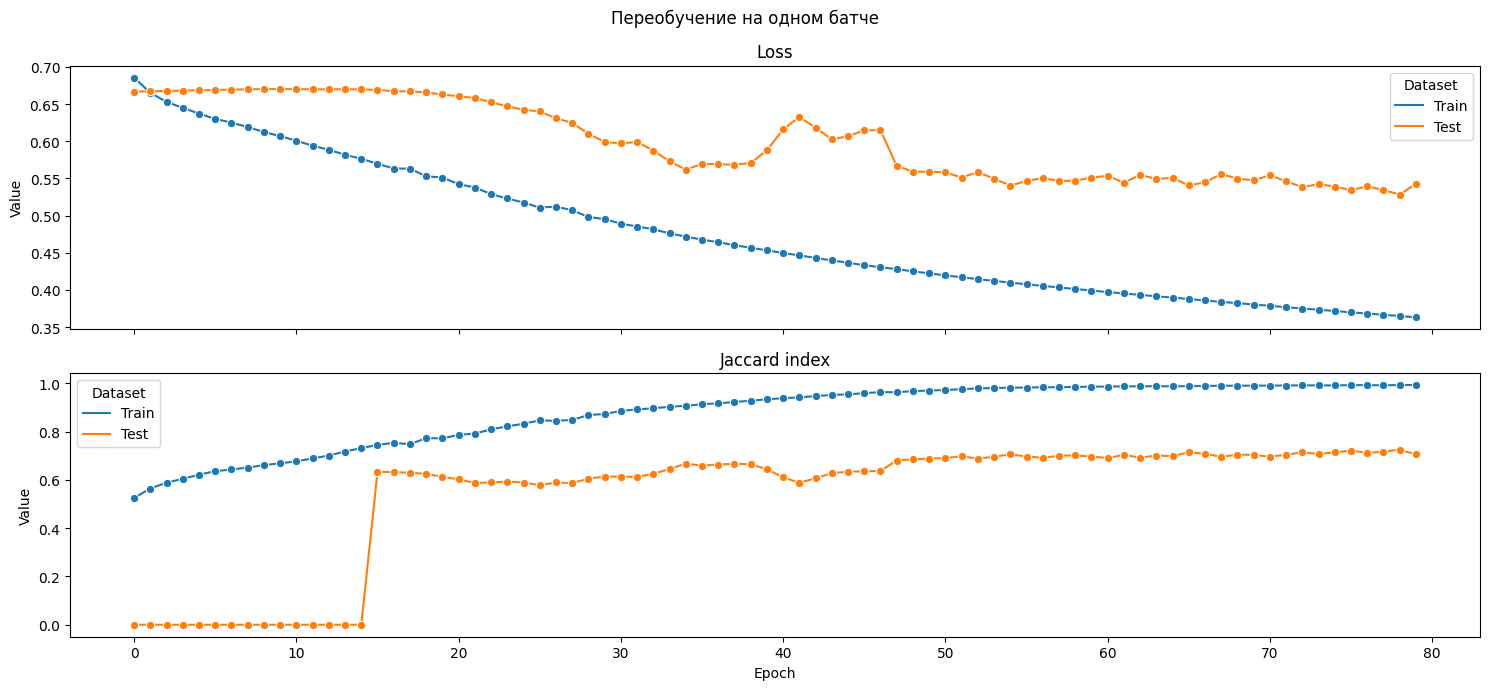

In [50]:
show_stats(stats, "Переобучение на одном батче", values=False)

Получаем отличные результаты на тренировочных данных и плохие - на тестовых. 

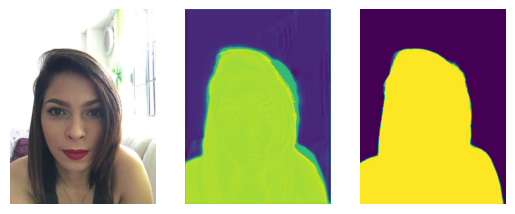

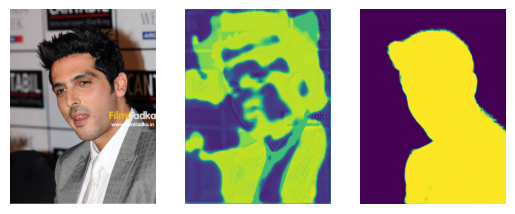

In [92]:
model.eval()

########### TRAIN #############
X, y = train_dataset[1]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_images([X, nn.functional.sigmoid(pred), y])

########### TEST ##############
X, y = test_dataset[1]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_images([X, nn.functional.sigmoid(pred), y])

### Полное обучение

In [29]:
reset_random_seeds()

In [30]:
batch_size = 8  # Максимально доступный GPU

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, train_loader, test_loader, checkpoints_dir="models/full").to_csv("models/full/stats.csv")

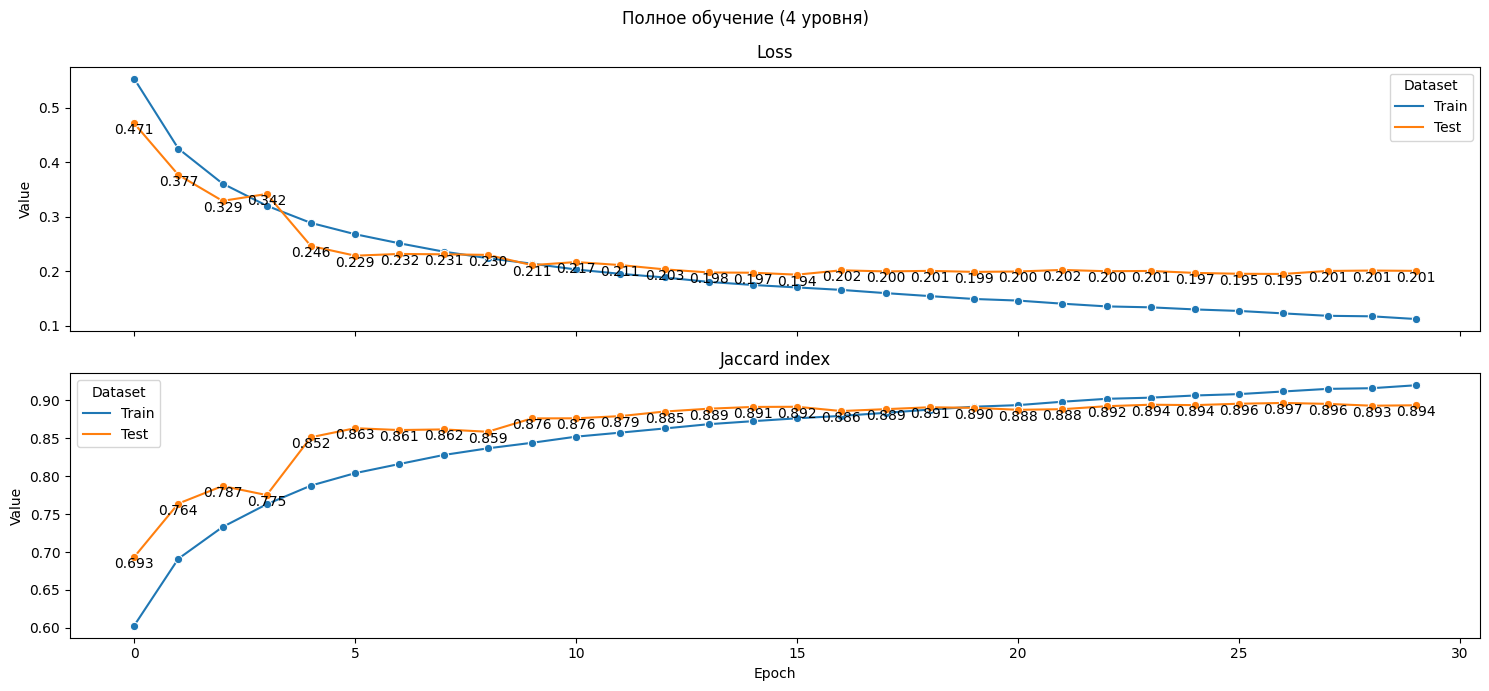

In [51]:
show_stats(pd.read_csv("models/full/stats.csv"), "Полное обучение (4 уровня)")

На графике видно, что самые лучшие результаты были в 15 и 26 эпохи. Наилучшей возмем 26 эпоху.

In [55]:
model = UNet()
model.load_state_dict(torch.load(f"models/full/epoch_26.pt"))
model.cuda().eval();

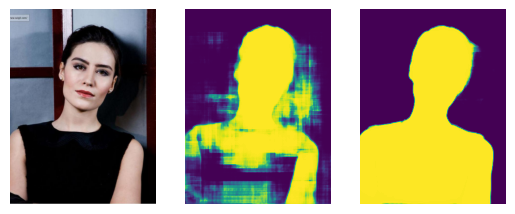

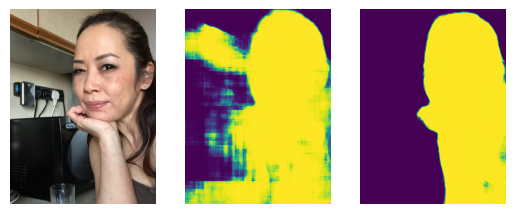

In [57]:
initial_worst_cases_idx = show_worst_test_cases(model, n=2)

Появились силуэты, но все равно что-то идет не так.

### Улучшение качества без изменения архитектуры

In [ ]:
reset_random_seeds()

Попробуем искусственно увеличить число тестовых данных за счет модификации имеющихся. Продублируем каждое тренировочное изображение, отразим и изменим некоторые параметры изображения.

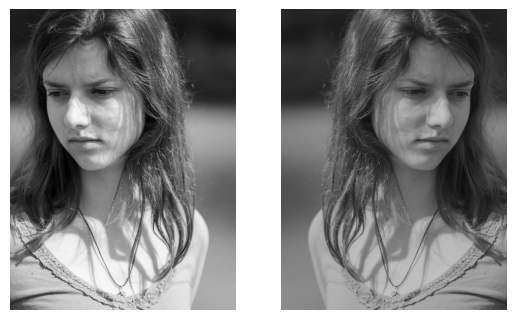

In [ ]:
augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=1),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    ]
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

image, _ = train_dataset[0]
augmented_image, _ = train_dataset_augmented[0]
show_images([image, augmented_image])

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset, copy.copy(train_dataset)]
)
train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

In [ ]:
model = UNet().cuda()
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, train_loader_extended, test_loader, checkpoints_dir="models/extended").to_csv(
    "models/extended/stats.csv")

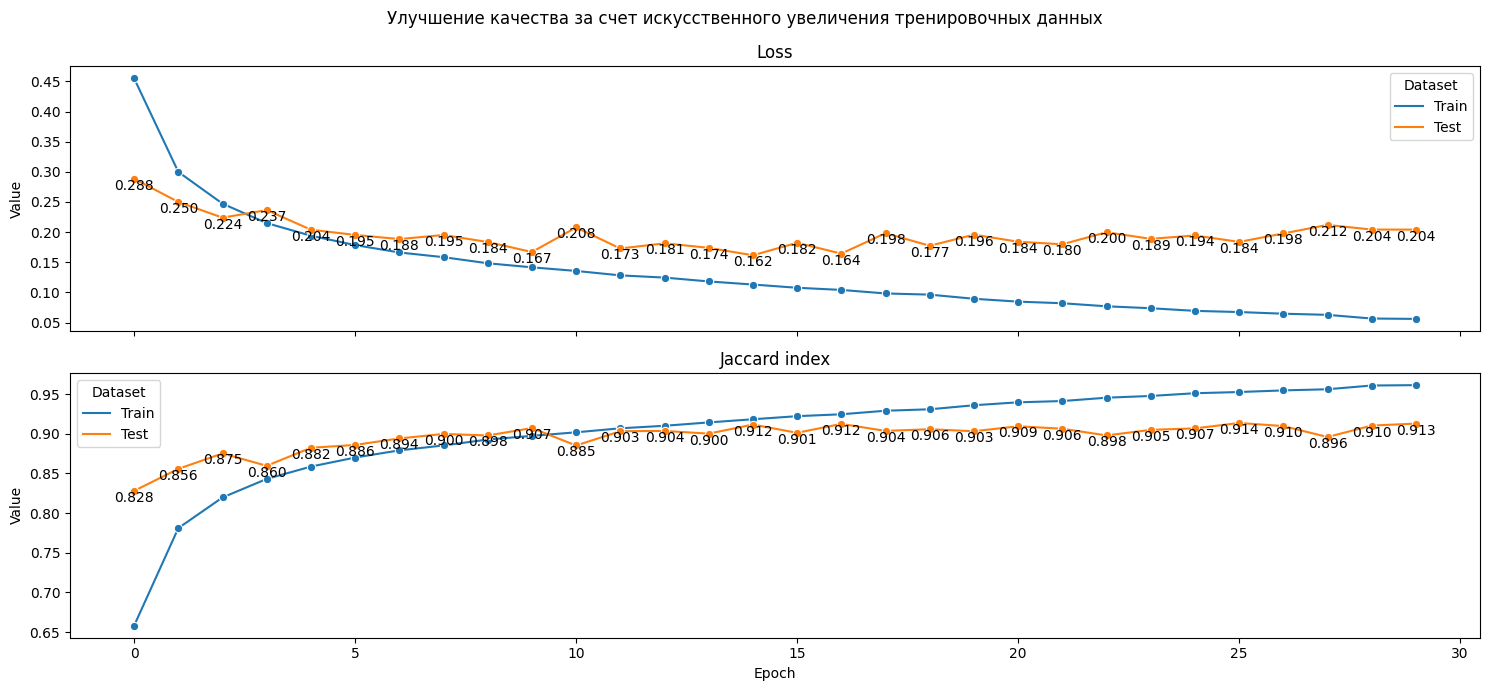

In [58]:
show_stats(pd.read_csv("models/extended/stats.csv"),
           "Улучшение качества за счет искусственного увеличения тренировочных данных")

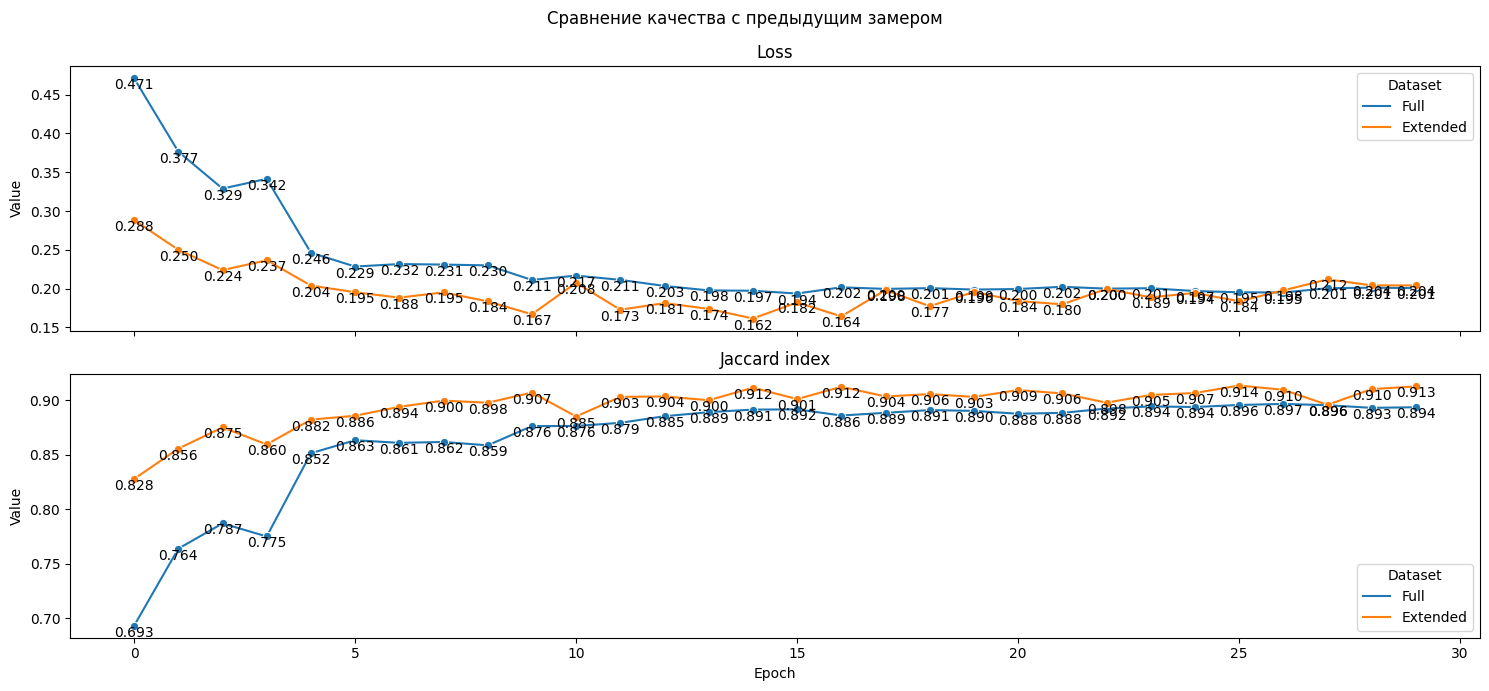

In [94]:
show_stats(pd.read_csv("stats.csv"),
           "Сравнение качества с предыдущим замером")

Как мы можем видеть на графике, после искусственного увеличения датасета результаты учлучшились на несколько десятых пункта. Но если посмотреть на худшие изоюражения с хорошей эпохи, результаты не так однозначны: намного хуже видны силуэты, и больше размытие.

In [99]:
model = UNet()
model.load_state_dict(torch.load(f"models/extended/epoch_14.pt"))
model.cuda().eval();

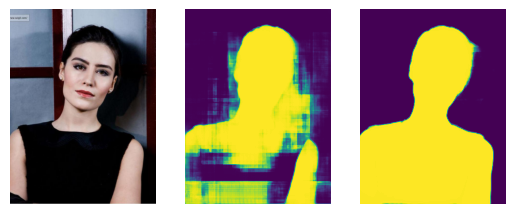

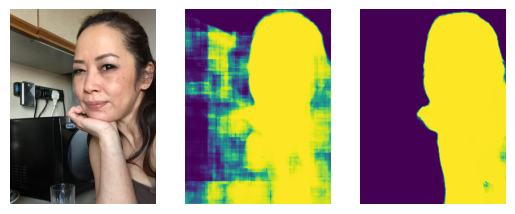

In [67]:
########### ИСХОДНЫЙ ДАТАСЕТ ##############
show_worst_test_cases(model, idx=initial_worst_cases_idx);

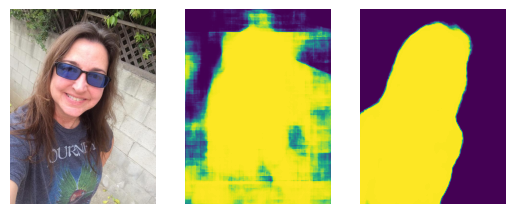

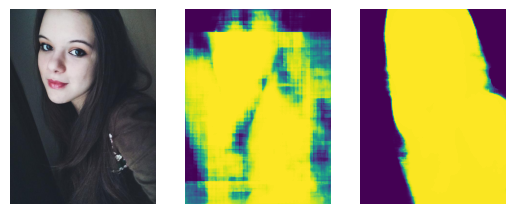

In [100]:
########### РАСШИРЕННЫЙ ДАТАСЕТ ##############
show_worst_test_cases(model, n=2);

#### Test-time аугментации

Попробуем применить модель на тестовых данных следующим образом:

передать модели 2 тестовых изображения: некоторое тестовое и его отображение. Затем объединим результаты, предварительно отразив второй результат.

In [73]:
class UNetHFlipWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = UNet()

    def forward(self, x):
        x = torch.cat([x, functional.hflip(x)])
        x = self.unet(x)

        x, x_alt = torch.chunk(x, 2)
        x_alt = functional.hflip(x_alt)

        stacked = torch.stack([x, x_alt])
        means = torch.mean(stacked, dim=0)

        return means

In [74]:
wrapped_model = UNetHFlipWrapper().cuda()
wrapped_model.unet.load_state_dict(model.state_dict());

In [101]:
print("Flip-wrapped test results (loss, jaccard):", test(wrapped_model, test_loader))

Test batch:   0%|          | 0/1 [00:00<?, ?it/s]

Flip-wrapped test results (loss, jaccard): (0.14094248414039612, 0.9185608625411987)


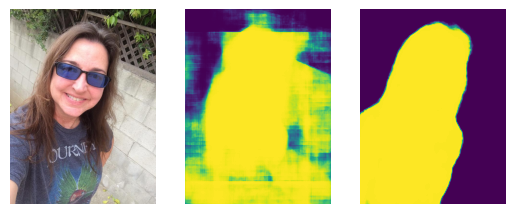

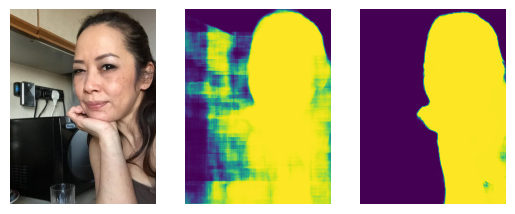

In [102]:
show_worst_test_cases(wrapped_model, n=2);

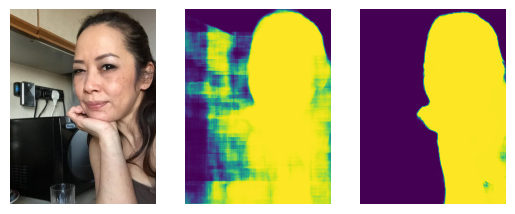

In [103]:
show_worst_test_cases(wrapped_model, idx=initial_worst_cases_idx[1:2]);

Не смотря на улучшение в значениях, визуально картинки не сильно поменялись.

### Улучшение качества через изменение архитектуры

Попробуем улучшить слабое место модели: слой, что имеет наименьшее разрешение, но наибольшее число каналов, то есть нижний слой U-Net. Добавим в него больше сверток (4 вместо двух)

In [24]:
class NConvBlock(nn.Module):
    def __init__(self, n_convs, in_channels, out_channels):
        super().__init__()

        convs = []
        for i in range(n_convs):
            convs += [
                nn.Conv2d(
                    in_channels if i == 0 else out_channels, out_channels, kernel_size=3, padding=1, bias=False
                    ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
        self.n_conv_block = nn.Sequential(*convs)

    def forward(self, x):
        return self.n_conv_block(x)


class LongBottomEncoder(nn.Module):
    def __init__(self, in_channels, n_down, n_bottom_convs):
        super().__init__()

        self.enc_layers = nn.ModuleList(
            [DoubleConv(in_channels, in_channels * 2)]
        )
        for i in range(n_down):
            in_channels *= 2
            self.enc_layers.append(
                nn.Sequential(
                    nn.MaxPool2d(2, 2),
                    (
                        DoubleConv(in_channels, in_channels * 2)
                        if i < n_down - 1 else
                        NConvBlock(n_bottom_convs, in_channels, in_channels * 2)
                    ),
                )
            )

    def forward(self, x):
        results = []
        for layer in self.enc_layers:
            x = layer(x)
            results.append(x)
        return results


class LongBottomUNet(nn.Module):

    def __init__(self, n_bottom_convs):
        super().__init__()
        self.encoder = LongBottomEncoder(in_channels=3, n_down=4, n_bottom_convs=n_bottom_convs)
        self.decoder = Decoder(in_channels=96, n_up=4)
        self.out_conv = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        *residuals, x = self.encoder(x)
        x = self.decoder(x, residuals)
        return self.out_conv(x)

In [ ]:
reset_random_seeds()

In [ ]:
model = LongBottomUNet(n_bottom_convs=4).cuda()
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, train_loader, test_loader, checkpoints_dir="models/new_architecture").to_csv(
    "models/new_architecture/stats.csv")

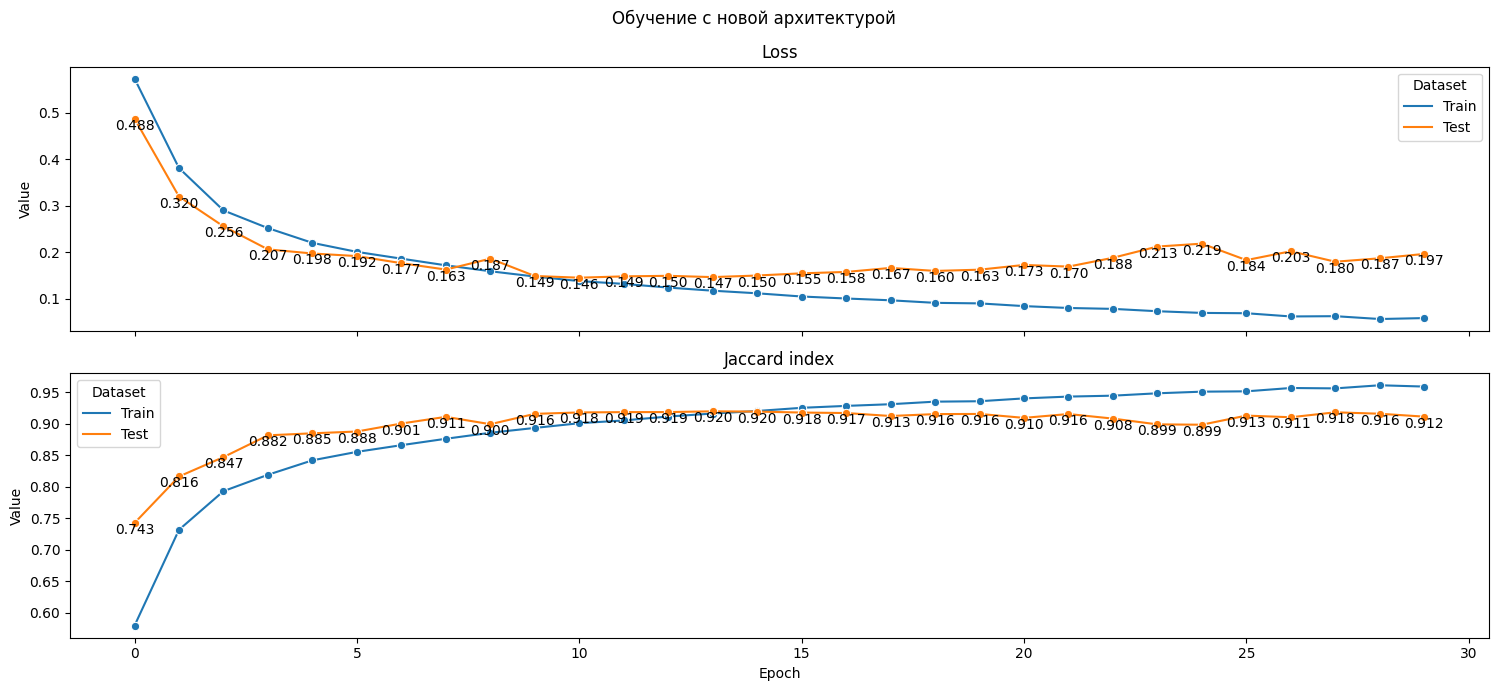

In [80]:
show_stats(pd.read_csv("models/new_architecture/stats.csv"), "Обучение с новой архитектурой")

Как видим на изображениях лучшей эпохи стало меньше помех на худшем случае.

In [25]:
model = LongBottomUNet(n_bottom_convs=4)
# model.load_state_dict(torch.load("models/new_architecture/epoch_13.pt"))
model.load_state_dict(torch.load("epoch_13.pt"))
model.cuda().eval();

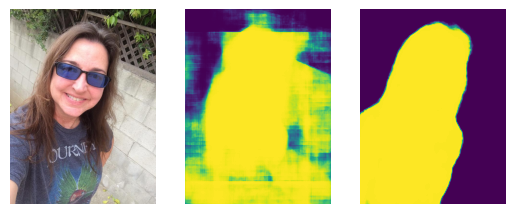

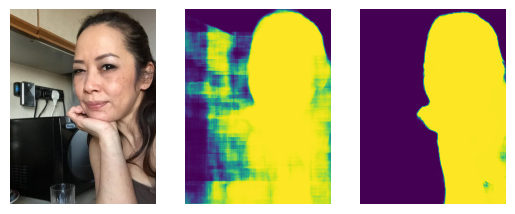

In [ ]:
############# БЫЛО #############
show_worst_test_cases(wrapped_model, n=2);

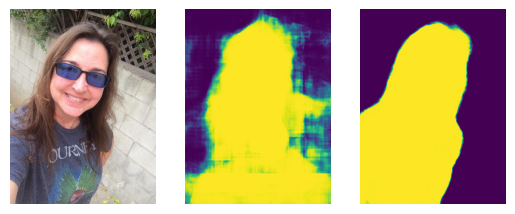

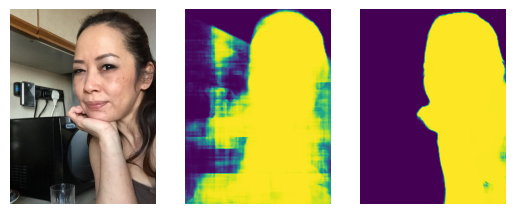

In [36]:
############# СТАЛО #############
show_worst_test_cases(model, n=2);

По индексам тоже видим улучшение по сравнению с предыдущими замерами.

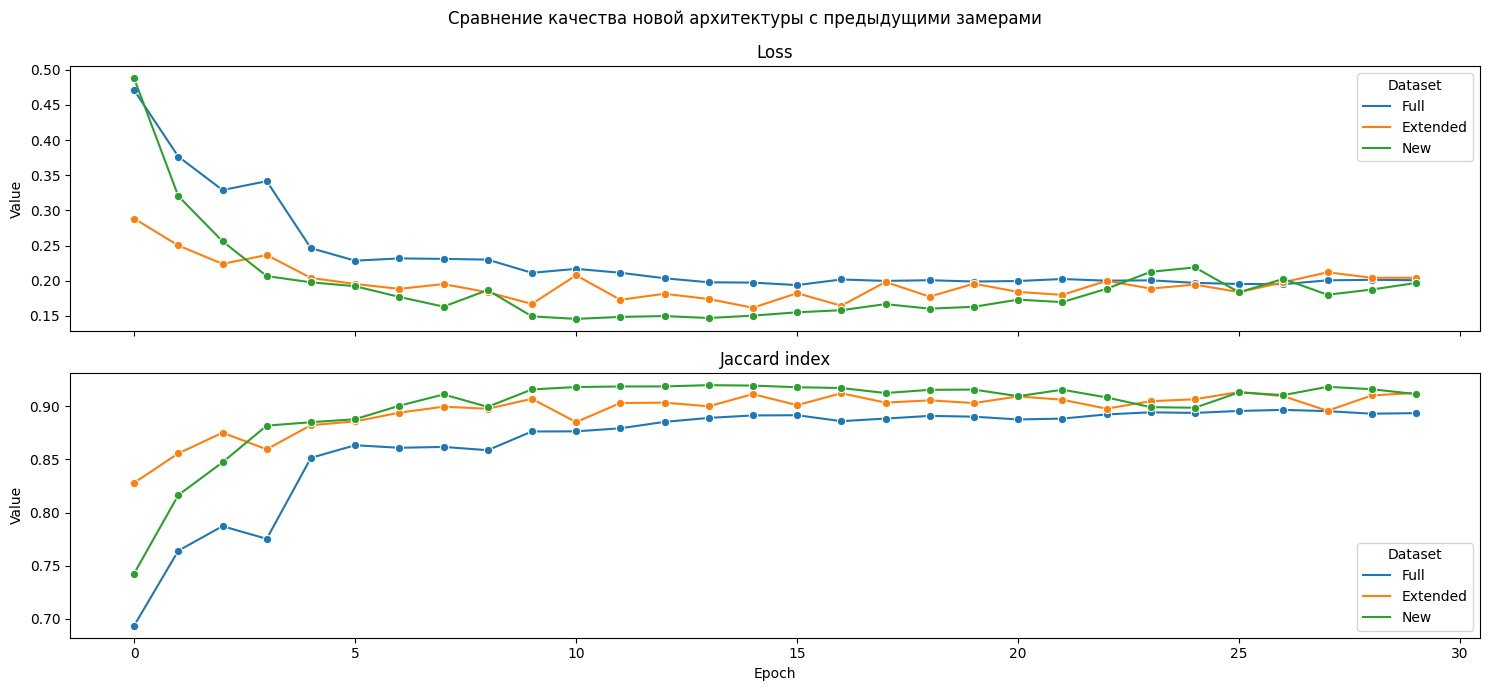

In [9]:
show_stats(pd.read_csv("stats.csv"),
           "Сравнение качества новой архитектуры с предыдущими замерами", values=False)

## Результаты

Удалось добиться следующих результатов:

| Условия | Лучшая эпоха | Loss | Jaccard |
| --- |--------------| --- | --- |
| Переобучение на одном батче | >60          | .528 | .725 |
| Исходный датасет | 26           | .195 | .897 |
| Искусственно расширенный датасет | 14           | .162 | .912 |
| Новая архитектура с удлиненным нижним уровнем на исходном датасете | 13           | .147 | .920 |
| Test-time аугментации |              | .141 | .919 |

## Выводы

- Даже на обычной конфигурации можем получить хорошие результаты.
- Искусственное расширение данных позволило улучшить результаты Loss и Jaccard.
- Test-time аугментации не дало ощутимых улучшений на худшем случае, но показало хорошие результаты метрик.
- Изменение строения модели (увеличение числа свёрток на нижнем уровне) позволяет ещё сильнее улучшить результаты с заметными улучшениеми в худших случаях.
- С каждым улучшением модель обучалась быстрее (порядковый номер хорошей эпохи был меньше)